# Introduction

This is the analysis of gut intestinal stem cell data as presented in Böttcher et al. We use in total **75,012** cells from **14 samples** in **6 conditions** (2 replicates in each mutant, 3 replicates in each control and 1 sample FVR only controls):

* Control (whole crypt)
* Control (FVR enriched)
* Control (FVR only)
* Mutant (Fltp deficient, whole crypt)
* Mutant (Fltp deficient, FVR enriched)
* Control (High fat diet project)

In this notebook, data are batch corrected and normalised.

We filtered cells by

* number of reads
* number of detected genes
* fraction of mitochondrial reads (< 10%) 


## Tasks in this notebook

In order to keep the notebook structure short and well-arranged, we have split the gut intestinal stem cell analysis into several parts:

1. Pre-processing and filtering
2. Preparation of Batch effect correction
3. Batch effect correction with adjusted Combat
4. Cell type annotation (control only) 
    * ISC subtype annotation
    * Goblet, Paneth, Tuft cell subtype annotation
    * EEC subtype annotation
5. Cell type data analysis with Graph abstraction (control only)
6. Pseudotime analysis of ISC-PC lineage
7. Differential expression analysis of Mutant and Control cells

This notebook covers **part 7**.

It must be noted that all differential expression tests are carried out in R using the package limma and are therefore not included in the notebook structure.

# Initialise scanpy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.colors as colors
import scanpy.api as sc
import matplotlib as mpl
import anndata
#import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import scipy as sci
import os

sc.settings.verbosity = 3                # amount of output
#sc.settings.set_dpi(60) # deprecated. low pixel number yields small inline figures
sc.logging.print_version_and_date()

Running Scanpy 1.3.1 on 2021-02-09 10:34.


In [2]:
import datetime

now = datetime.datetime.now()

In [3]:
today = now.strftime("%y%m%d")

## Load extensions

In [4]:
%run '~/Documents/Python/maren_codes/bar_frequency.py'
%run '~/Documents/Python/maren_codes/cal_density.py'
%run '~/Documents/Python/maren_codes/genes_to_xls.py'

Set custom color bar.

In [5]:
colors2 = pl.cm.RdYlBu_r(np.linspace(0, 1, 128))
colors3 = pl.cm.Greys_r(0.7)
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

## Custom dotplot

In [6]:
from scanpy import settings
from scanpy import logging as logg
from scanpy.plotting import *
#from scanpy..utils import sanitize_anndata
from pandas.api.types import is_categorical_dtype

def sanitize_anndata(adata):
    adata._sanitize()

def _prepare_dataframe(adata, var_names, groupby=None, use_raw=None, log=False, num_categories=7):
    """
    Given the anndata object, prepares a data frame in which the row index are the categories
    defined by group by and the columns correspond to var_names.
    Parameters
    ----------
    adata : :class:`~anndata.AnnData`
        Annotated data matrix.
    var_names : `str` or list of `str`
        `var_names` should be a valid subset of  `adata.var_names`.
    groupby : `str` or `None`, optional (default: `None`)
        The key of the observation grouping to consider. It is expected that
        groupby is a categorical. If groupby is not a categorical observation,
        it would be subdivided into `num_categories`.
    log : `bool`, optional (default: `False`)
        Use the log of the values
    use_raw : `bool`, optional (default: `None`)
        Use `raw` attribute of `adata` if present.
    num_categories : `int`, optional (default: `7`)
        Only used if groupby observation is not categorical. This value
        determines the number of groups into which the groupby observation
        should be subdivided.
    Returns
    -------
    Tuple of `pandas.DataFrame` and list of categories.
    """
    from scipy.sparse import issparse
    sanitize_anndata(adata)
    if use_raw is None and adata.raw is not None: use_raw = True
    if isinstance(var_names, str):
        var_names = [var_names]

    if groupby is not None:
        if groupby not in adata.obs_keys():
            raise ValueError('groupby has to be a valid observation. Given value: {}, '
                             'valid observations: {}'.format(groupby, adata.obs_keys()))

    if use_raw:
        matrix = adata.raw[:, var_names].X
    else:
        matrix = adata[:, var_names].X

    if issparse(matrix):
        matrix = matrix.toarray()
    if log:
        matrix = np.log1p(matrix)

    obs_tidy = pd.DataFrame(matrix, columns=var_names)
    if groupby is None:
        groupby = ''
        categorical = pd.Series(np.repeat('', len(obs_tidy))).astype('category')
    else:
        if not is_categorical_dtype(adata.obs[groupby]):
            # if the groupby column is not categorical, turn it into one
            # by subdividing into  `num_categories` categories
            categorical = pd.cut(adata.obs[groupby], num_categories)
        else:
            categorical = adata.obs[groupby]

    obs_tidy.set_index(categorical, groupby, inplace=True)
    categories = obs_tidy.index.categories

    return categories, obs_tidy

def pos_mean(group):
    return group[group>0].mean()

def dotplot(adata, var_names, groupby=None, use_raw=None, log=False, num_categories=7, max_scale=None, min_scale=None,
            color_map='Reds', figsize=None, var_group_positions=None, var_group_labels=None,
            var_group_rotation=None, show=None, save=None, **kwds):
    """\
    Makes a _dot plot_ of the expression values of `var_names`.
    For each var_name and each `groupby` category a dot is plotted. Each dot
    represents two values: mean expression within each category (visualized by
    color) and fraction of cells expressing the var_name in the
    category. (visualized by the size of the dot).  If groupby is not given, the
    dotplot assumes that all data belongs to a single category. A gene is not
    considered expressed if the expression value in the adata (or adata.raw) is
    equal to zero.
    For instance, for each marker gene, the mean value and the percentage of cells
    expressing the gene can be visualized for each cluster.
    Parameters
    ----------
    adata : :class:`~scanpy.api.AnnData`
        Annotated data matrix.
    var_names : `str` or list of `str`
        var_names should be a valid subset of  `.var_names`.
    groupby : `str` or `None`, optional (default: `None`)
        The key of the observation grouping to consider. It is expected that groupby is
        a categorical. If groupby is not a categorical observation, it would be
        subdivided into `num_categories`.
    log : `bool`, optional (default: `False`)
        Use the log of the values
    use_raw : `bool`, optional (default: `None`)
        Use `raw` attribute of `adata` if present.
    num_categories : `int`, optional (default: `7`)
        Only used if groupby observation is not categorical. This value determines
        the number of groups into which the groupby observation should be subdivided.
    max_scale : `float` (default: `None`) - enable global color scaling if not `None`
    min_scale : `float` (default: `None`) - enable global color scaling if not `None`
    color_map : `str`, optional (default: `Reds`)
        String denoting matplotlib color map.
    figsize : (float, float), optional (default: None)
        Figure size (width, height. If not set, the figure width is set based on the
        number of  `var_names` and the height is set to 10.
    var_group_positions :  list of `tuples`.
        Use this parameter to highlight groups of `var_names`. This will draw a 'bracket'
        on top of the plot between the given start and end positions. If the
        parameter `var_group_labels` is set, the corresponding labels is added on
        top of the bracket. E.g. var_group_positions = [(4,10)] will add a bracket
        between the fourth var_name and the tenth var_name. By giving more
        positions, more brackets are drawn.
    var_group_labels : list of `str`
        Labels for each of the var_group_positions that want to be highlighted.
    var_group_rotation : `float` (default: `None`)
        Label rotation degrees. By default, labels larger than 4 characters are rotated 90 degrees
    {show_save_ax}
    **kwds : keyword arguments
        Are passed to `matplotlib.pyplot.scatter`.
    Returns
    -------
    A list of `matplotlib.Axes` where the first ax is the groupby categories colorcode, the
    second axis is the heatmap and the third axis is the colorbar.
    """
    
    if use_raw is None and adata.raw is not None: use_raw = True
    categories, obs_tidy = _prepare_dataframe(adata, var_names, groupby, use_raw, log, num_categories)

    # for if category defined by groupby (if any) compute for each var_name
    # 1. the mean value over the category
    # 2. the fraction of cells in the category having a value > 0

    # 1. compute mean value
    mean_obs = obs_tidy.groupby(level=0).apply(pos_mean)

    # 2. compute fraction of cells having value >0
    # transform obs_tidy into boolean matrix
    obs_bool = obs_tidy.astype(bool)

    # compute the sum per group which in the boolean matrix this is the number
    # of values >0, and divide the result by the total number of values in the group
    # (given by `count()`)
    fraction_obs = obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()

    if figsize is None:
        height = len(categories) * 0.3 + 1  # +1 for labels
        # if the number of categories is small (eg 1 or 2) use
        # a larger height
        height = max([1.5, height])
        heatmap_width = len(var_names) * 0.5
        width = heatmap_width + 1.6 + 1  # +1.6 to account for the colorbar and  + 1 to account for labels
    else:
        width, height = figsize
        heatmap_width = width * 0.75

    # colorbar ax width should not change with differences in the width of the image
    # otherwise can become too small
    colorbar_width = 0.4
    colorbar_width_spacer = 0.7
    size_legend_width = 0.5

    if var_group_positions is not None and len(var_group_positions) > 0:
        # add some space in case 'brackets' want to be plotted on top of the image
        height_ratios = [0.5, 10]
    else:
        height_ratios = [0, 10.5]

    # define a layout of 2 rows x 4 columns
    # first row is for 'brackets' (if no brackets needed, the height of this row is zero)
    # second row is for main content. This second row
    # is divided into 4 axes:
    #   first ax is for the main figure
    #   second ax is for the color bar legend
    #   third ax is for an spacer that avoids the ticks
    #    from the color bar to be hidden beneath the size lengend axis
    #   fourth ax is to plot the size legend
    from matplotlib import gridspec
    fig = pl.figure(figsize=(width, height))
    axs = gridspec.GridSpec(nrows=2, ncols=4, left=0.05, right=0.48, wspace=0.05, hspace=0.04,
                            width_ratios=[heatmap_width, colorbar_width, colorbar_width_spacer, size_legend_width],
                            height_ratios=height_ratios)
    if len(categories) < 4:
        # when few categories are shown, the colorbar and size legend
        # need to be larger than the main plot, otherwise they would look
        # compressed. For this, the dotplot ax is split into two:
        axs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=axs[1, 0],
                                                height_ratios=[len(categories) * 0.3, 1])
        dot_ax = fig.add_subplot(axs2[0])
    else:
        dot_ax = fig.add_subplot(axs[1, 0])

    color_legend = fig.add_subplot(axs[1, 1])

    # to keep the size_legen of about the same height, irrespective
    # of the number of categories, the fourth ax is subdivided into two parts
    size_legend_height = min(1.3, height)
    # wspace is proportional to the width but a constant value is
    # needed such that the spacing is the same for thinner or wider images.
    wspace = 10.5 / width
    axs3 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=axs[1, 3], wspace=wspace,
                                            height_ratios=[size_legend_height / height,
                                                           (height - size_legend_height) / height])
    size_legend = fig.add_subplot(axs3[0])

    # make scatter plot in which
    # x = var_names
    # y = groupby category
    # size = fraction
    # color = mean expression

    y, x = np.indices(mean_obs.shape)
    y = y.flatten()
    x = x.flatten()
    frac = fraction_obs.values.flatten()
    mean_flat = mean_obs.values.flatten()
    cmap = pl.get_cmap(color_map)

    size = (frac * 10) ** 2

    import matplotlib.colors
    if max_scale is None:
        max_scale = max(mean_flat)
        
    if min_scale is None:
        min_scale = max(0,min(mean_flat))
    
    normalize = matplotlib.colors.Normalize(vmax=max_scale, vmin=min_scale)
    colors = [cmap(normalize(value)) for value in mean_flat]
    
    dot_ax.scatter(x, y, color=colors, s=size, cmap=cmap, norm=None, edgecolor='none', **kwds)
    y_ticks = range(mean_obs.shape[0])
    dot_ax.set_yticks(y_ticks)
    dot_ax.set_yticklabels([mean_obs.index[idx] for idx in y_ticks])

    x_ticks = range(mean_obs.shape[1])
    dot_ax.set_xticks(x_ticks)
    dot_ax.set_xticklabels([mean_obs.columns[idx] for idx in x_ticks], rotation=90)
    dot_ax.tick_params(axis='both', labelsize='small')
    dot_ax.grid(False)
    dot_ax.set_xlim(-0.5, len(var_names) + 0.5)
    dot_ax.set_ylabel(groupby)

    # to be consistent with the heatmap plot, is better to
    # invert the order of the y-axis, such that the first group is on
    # top
    ymin, ymax = dot_ax.get_ylim()
    dot_ax.set_ylim(ymax+0.5, ymin - 0.5)

    dot_ax.set_xlim(-1, len(var_names) + 0.5)

    # plot group legends on top of dot_ax (if given)
    if var_group_positions is not None and len(var_group_positions) > 0:
        gene_groups_ax = fig.add_subplot(axs[0, 0], sharex=dot_ax)
        _plot_gene_groups_brackets(gene_groups_ax, group_positions=var_group_positions,
                                   group_labels=var_group_labels,
                                   rotation=var_group_rotation)

    # plot colorbar
    import matplotlib.colorbar
    matplotlib.colorbar.ColorbarBase(color_legend, cmap=cmap, norm=normalize)

    # plot size bar
    fracs_legend = np.array([0.25, 0.50, 0.75, 1])
    size = (fracs_legend * 10) ** 2
    color = [cmap(normalize(value)) for value in np.repeat(max(mean_flat) * 0.7, len(size))]
    size_legend.scatter(np.repeat(0, len(size)), range(len(size)), s=size, color=color)
    size_legend.set_yticks(range(len(size)))
    size_legend.set_yticklabels(["{:.0%}".format(x) for x in fracs_legend])

    size_legend.tick_params(axis='y', left=False, labelleft=False, labelright=True)

    # remove x ticks and labels
    size_legend.tick_params(axis='x', bottom=False, labelbottom=False)

    # remove surrounding lines
    size_legend.spines['right'].set_visible(False)
    size_legend.spines['top'].set_visible(False)
    size_legend.spines['left'].set_visible(False)
    size_legend.spines['bottom'].set_visible(False)
    size_legend.grid(False)

    ymin, ymax = size_legend.get_ylim()
    size_legend.set_ylim(ymin, ymax+0.5)

    utils.savefig_or_show('dotplot', show=show, save=save)
    return axs

# Load data

Load the data set with all cells and all genes that is batch effect corrected with `ComBat` and the zero-fix.

In [8]:
adata = sc.read('./../data/gut_AB_AL_log_cor_combat_normed.h5')

In [9]:
adata.obs_names_make_unique()

In [10]:
adata

AnnData object with n_obs × n_vars = 72290 × 2000 
    obs: 'sample', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'genetics', 'S_score', 'G2M_score', 'phase'
    var: 'mean', 'dispersion'
    uns: 'neighbors', 'pca', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [11]:
pd.value_counts(adata.obs['genetics'])

control    56292
mutant     15998
Name: genetics, dtype: int64

Load annotated control cells.

In [12]:
alin = sc.read('./../data/gut_AB_AL_log_cor_control_anno.h5ad') 

In [13]:
alin

AnnData object with n_obs × n_vars = 56240 × 2000 
    obs: 'sample', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'genetics', 'S_score', 'G2M_score', 'phase', 'louvain', 'cell_type', 'ISC_score', 'EEC_score', 'Enterocyte_score', 'PC_score', 'GC_score', 'Tuft_score', 'refined_clustering', 'major_cell_type', 'proma_cell_type'
    var: 'mean', 'dispersion'
    uns: 'cell_type_colors', 'louvain', 'louvain_colors', 'major_cell_type_colors', 'neighbors', 'paga', 'pca', 'phase_colors', 'proma_cell_type_colors', 'rank_genes_groups', 'refined_clustering_colors', 'refined_clustering_sizes', 'sample_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

## Add cell-type info to full data set

In [14]:
alin.obs['refined_clustering'].cat.categories

Index(['EC', 'EC-Reg4', 'Enterocyte', 'Enterocyte progenitor',
       'Ghrl progenitor', 'Goblet cell', 'Goblet progenitor', 'ISC',
       'Isl1/Arx progenitor', 'Lgr5+ EEC', 'Ngn3 progenitor', 'Paneth 1',
       'Paneth 2', 'Paneth primed ISC', 'Paneth progenitor', 'Pax4 progenitor',
       'SAKD', 'SIA', 'SIK', 'SIL-P', 'SILA', 'SIN',
       'Sox4+ early EE progenitor', 'Tuft 1', 'Tuft 2', 'Tuft progenitor',
       'early Goblet'],
      dtype='object')

In [15]:
alin.obs['major_cell_type'].cat.categories

Index(['Enterocyte', 'Goblet cell', 'ISC', 'EEC', 'Paneth cell', 'Tuft cell'], dtype='object')

In [18]:
adata.obs['cell_type'] = pd.Categorical(np.repeat('0', adata.n_obs))
adata.obs['cell_type'] = adata.obs['cell_type'].cat.add_categories([
    'EEC', 'Enterocyte', 'Goblet cell', 'ISC', 'Paneth cell', 'Tuft cell'])

In [19]:
adata.obs['cell_type'][alin.obs.index] = alin.obs['major_cell_type']
adata.obs['cell_type'] = adata.obs['cell_type'].cat.remove_unused_categories()

In [20]:
pd.value_counts(adata.obs['cell_type'])

Paneth cell    16796
Enterocyte     16562
0              16050
ISC            10560
Goblet cell     7358
EEC             2873
Tuft cell       2091
Name: cell_type, dtype: int64

Remove the cells from control that have a `0` label (removed in previous steps).

In [23]:
adata = adata[np.invert(np.logical_and(adata.obs['cell_type']=='0', 
                                       adata.obs['genetics']=='control'))]

In [24]:
adata

View of AnnData object with n_obs × n_vars = 72238 × 2000 
    obs: 'sample', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'genetics', 'S_score', 'G2M_score', 'phase', 'cell_type'
    var: 'mean', 'dispersion'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [27]:
adata.obs['cell_type_refined'] = pd.Categorical(np.repeat('0', adata.n_obs))
adata.obs['cell_type_refined'] = adata.obs['cell_type_refined'].cat.add_categories([
    'ISC', 'Enterocyte', 'Enterocyte progenitor', 'Goblet progenitor',
       'early Goblet', 'Goblet cell', 'Paneth primed ISC',
       'Paneth progenitor', 'Paneth 1', 'Paneth 2', 'Lgr5+ EEC',
       'Sox4+ early EE progenitor', 'Ngn3 progenitor', 'Isl1/Arx progenitor',
       'Pax4 progenitor', 'Ghrl progenitor', 'EC', 'EC-Reg4', 'SAKD', 'SIA',
       'SIK', 'SIL-P', 'SILA', 'SIN', 'Tuft progenitor',
       'Tuft 1', 'Tuft 2'])

In [28]:
adata.obs['cell_type_refined'][alin.obs.index] = alin.obs['refined_clustering']
adata.obs['cell_type_refined'] = adata.obs['cell_type_refined'].cat.remove_unused_categories()

In [29]:
pd.value_counts(adata.obs['cell_type_refined'])

0                            15998
Paneth 1                     14548
Enterocyte progenitor        10705
ISC                           8838
Enterocyte                    5857
Goblet cell                   4335
Paneth primed ISC             1722
Goblet progenitor             1512
early Goblet                  1511
Paneth progenitor             1325
Paneth 2                       923
Tuft 2                         832
Tuft progenitor                820
Sox4+ early EE progenitor      443
Tuft 1                         439
EC-Reg4                        343
EC                             342
Ngn3 progenitor                332
SIK                            327
Lgr5+ EEC                      277
Ghrl progenitor                144
Isl1/Arx progenitor            129
SAKD                           110
Pax4 progenitor                100
SILA                           100
SIN                             91
SIA                             71
SIL-P                           64
Name: cell_type_refi

# Assign mutants to cell types 

In [30]:
sc.pp.neighbors(adata, n_neighbors=30)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:55.09) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:01:34.78) --> added
    'X_umap', UMAP coordinates (adata.obsm)


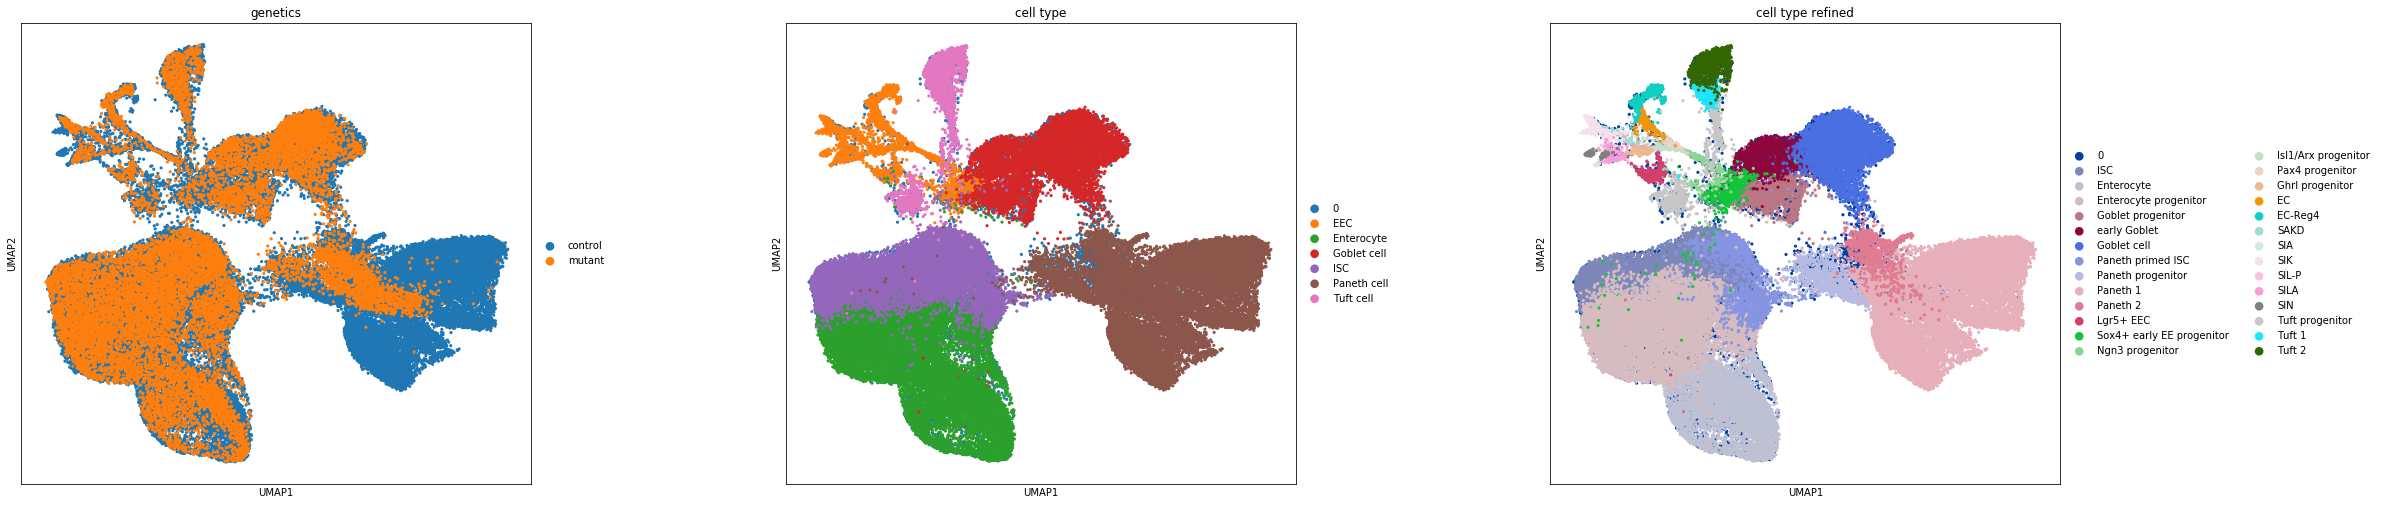

In [31]:
rcParams['figure.figsize']=(8,8)
sc.pl.umap(adata, color=['genetics', 'cell_type', 'cell_type_refined'], size=40)


## Alternative: Assign by nearest neighbours

The majority vote approach has several issues. First of all, we show that we have clustered both mutants and controls together, and repeated the clustering for controls only. Second, the clustering changes slightly when we included or excluded the mutants. When we use the majority vote approach for each cluster, the boundaries of ISCs, TAs and enterocytes are smeared out. 

The alternative approach is to use a k-nearest neighbour approach to assign each cell according to the assignment of its nearest neighbours. 

In [32]:
connections = adata.uns['neighbors']['connectivities'].tocoo()

In [33]:
adata.obs['cell_type_test']=adata.obs['cell_type_refined']

In [34]:
mutant_idx = np.flatnonzero(np.in1d(adata.obs['genetics'], 'mutant'))
for idx in mutant_idx:
    nn = connections.getrow(idx).nonzero()[1]
    nn_ctrl = nn[np.flatnonzero(np.in1d(adata.obs['genetics'][nn], 'control'))]
    table = pd.value_counts(adata.obs['cell_type_test'][nn_ctrl])
    if table.values[0]>0:
        adata.obs['cell_type_test'][idx] = table.index[0]

In [35]:
adata.obs['cell_type_test'] = adata.obs['cell_type_test'].cat.remove_unused_categories()

In [36]:
pd.value_counts(adata.obs['cell_type_test'])

Paneth 1                     15741
Enterocyte progenitor        14354
ISC                          11771
Enterocyte                    7924
Goblet cell                   6304
Paneth primed ISC             2283
Goblet progenitor             2133
early Goblet                  2091
Paneth progenitor             1664
Paneth 2                      1359
Tuft 2                        1169
Tuft progenitor               1022
Tuft 1                         580
Sox4+ early EE progenitor      561
EC-Reg4                        505
SIK                            464
EC                             462
Ngn3 progenitor                417
Lgr5+ EEC                      376
Ghrl progenitor                174
Isl1/Arx progenitor            158
SAKD                           158
SILA                           141
Pax4 progenitor                130
SIN                             99
SIA                             97
SIL-P                           96
0                                5
Name: cell_type_test

In [37]:
pd.crosstab(adata[adata.obs['cell_type_test']=='Paneth 1'].obs['genetics'], 
            adata[adata.obs['cell_type_test']=='Paneth 1'].obs['phase'],margins=True, normalize=0)

phase,G1,G2M,S
genetics,,,
control,0.962469,0.001100,0.036431
mutant,0.929589,0.000838,0.069573
All,0.959977,0.001080,0.038943


In [39]:
adata.obs['cell_type_test'][np.in1d(adata.obs['cell_type_test'], ['0'])] = np.repeat(
    'Paneth progenitor', np.in1d(adata.obs['cell_type_test'], ['0']).sum()) 
adata.obs['cell_type_test'] = adata.obs['cell_type_test'].cat.remove_unused_categories()


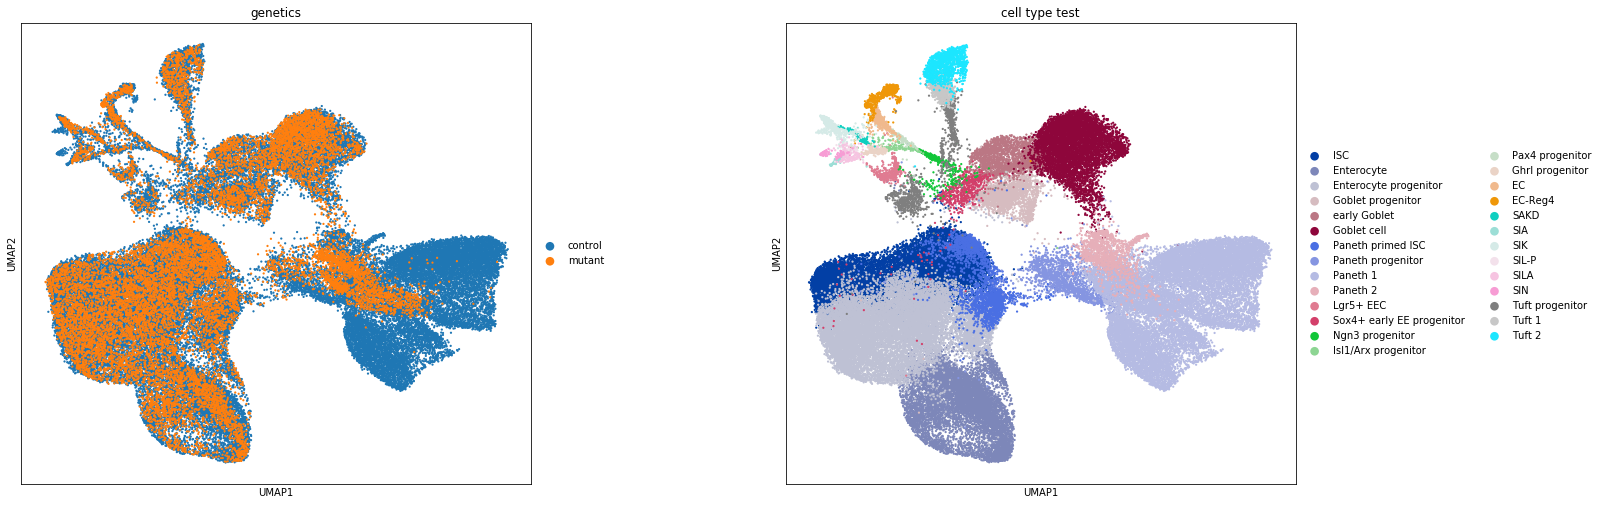

In [40]:
rcParams['figure.figsize']=(8,8)
sc.pl.umap(adata, color=['genetics', 'cell_type_test'], size=20)

In [41]:
pd.crosstab(adata.obs['cell_type_test'], adata.obs['cell_type_refined'])

cell_type_refined,0,ISC,Enterocyte,Enterocyte progenitor,Goblet progenitor,early Goblet,Goblet cell,Paneth primed ISC,Paneth progenitor,Paneth 1,...,EC-Reg4,SAKD,SIA,SIK,SIL-P,SILA,SIN,Tuft progenitor,Tuft 1,Tuft 2
cell_type_test,,,,,,,,,,,,,,,,,,,,,
ISC,2933,8838,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enterocyte,2067,0,5857,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Enterocyte progenitor,3649,0,0,10705,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Goblet progenitor,621,0,0,0,1512,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
early Goblet,580,0,0,0,0,1511,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Goblet cell,1969,0,0,0,0,0,4335,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Paneth primed ISC,561,0,0,0,0,0,0,1722,0,0,...,0,0,0,0,0,0,0,0,0,0
Paneth progenitor,344,0,0,0,0,0,0,0,1325,0,...,0,0,0,0,0,0,0,0,0,0
Paneth 1,1193,0,0,0,0,0,0,0,0,14548,...,0,0,0,0,0,0,0,0,0,0


In [8]:
adata.obs['cell_type_test'].cat.categories

Index(['ISC', 'Enterocyte', 'Enterocyte progenitor', 'Goblet progenitor',
       'early Goblet', 'Goblet cell', 'Paneth primed ISC', 'Paneth progenitor',
       'Paneth 1', 'Paneth 2', 'Lgr5+ EEC', 'Sox4+ early EE progenitor',
       'Ngn3 progenitor', 'Isl1/Arx progenitor', 'Pax4 progenitor',
       'Ghrl progenitor', 'EC', 'EC-Reg4', 'SAKD', 'SIA', 'SIK', 'SIL-P',
       'SILA', 'SIN', 'Tuft progenitor', 'Tuft 1', 'Tuft 2'],
      dtype='object')

In [9]:
adata.obs['proma_cell_type'] = adata.obs['cell_type_test'].cat.add_categories([
     "Paneth cell" , "EE progenitor"   ,"EEC" ,
      'Tuft cell'])
adata.obs['proma_cell_type'][np.in1d(adata.obs['cell_type_test'], 
                                    ['ISC', 'Paneth primed ISC'])] = np.repeat(
    'ISC', np.in1d(adata.obs['cell_type_test'], 
                                         ['ISC', 'Paneth primed ISC']).sum())
adata.obs['proma_cell_type'][np.in1d(adata.obs['cell_type_test'], 
                                    ['Paneth 1', 'Paneth 2'])] = np.repeat(
    'Paneth cell', np.in1d(adata.obs['cell_type_test'], 
                                         ['Paneth 1', 'Paneth 2']).sum())
adata.obs['proma_cell_type'][np.in1d(adata.obs['cell_type_test'], 
                                    ['Lgr5+ EEC','Sox4+ early EE progenitor', 
                                     'Ngn3 progenitor'])] = np.repeat(
    'EE progenitor', np.in1d(adata.obs['cell_type_test'], 
                                         ['Lgr5+ EEC','Sox4+ early EE progenitor', 
                                          'Ngn3 progenitor']).sum())
adata.obs['proma_cell_type'][np.in1d(adata.obs['cell_type_test'], 
                                    [ 'Isl1/Arx progenitor','Pax4 progenitor', 
                                                      'Ghrl progenitor', 'EC', 'EC-Reg4', 'SAKD', 'SIA',
                                                      'SIK', 'SIL-P', 'SILA', 'SIN'])] = np.repeat(
    'EEC', np.in1d(adata.obs['cell_type_test'], 
                                         [ 'Isl1/Arx progenitor','Pax4 progenitor', 
                                                      'Ghrl progenitor', 'EC', 'EC-Reg4', 'SAKD', 'SIA',
                                                      'SIK', 'SIL-P', 'SILA', 'SIN']).sum())


adata.obs['proma_cell_type'][np.in1d(adata.obs['cell_type_test'], 
                                    ['Tuft 1', 'Tuft 2'])] = np.repeat(
    'Tuft cell', np.in1d(adata.obs['cell_type_test'], 
                                         ['Tuft 1', 'Tuft 2']).sum())
adata.obs['proma_cell_type'] = adata.obs['proma_cell_type'].cat.remove_unused_categories()

In [10]:
adata.obs['proma_cell_type']=adata.obs['proma_cell_type'].cat.reorder_categories([
    'ISC', 'Enterocyte progenitor','Enterocyte',  
    'Goblet progenitor', 'early Goblet', 'Goblet cell',
       'Paneth progenitor',  'Paneth cell', 'EE progenitor',
       'EEC','Tuft progenitor', 'Tuft cell'])

In [11]:
adata.obs['proma_cell_type'].cat.categories

Index(['ISC', 'Enterocyte progenitor', 'Enterocyte', 'Goblet progenitor',
       'early Goblet', 'Goblet cell', 'Paneth progenitor', 'Paneth cell',
       'EE progenitor', 'EEC', 'Tuft progenitor', 'Tuft cell'],
      dtype='object')

In total, it seems that the nearest neighbour approach does not work better than using the original clustering. 

In [34]:
sc.write(adata=adata, filename='./../data/gut_AB_AL_control_mutants_anno.h5ad')

## Create correlation heatmap

In order to ensure that our majority vote mapping resolves the correct cell types in control and mutant (*i.e.* the corresponding cell types are highly correlated), we display the correlation of the highly variable genes. 

In [7]:
adata = sc.read('./../data/gut_AB_AL_control_mutants_anno.h5ad')

In [12]:
annot_key='proma_cell_type'

for genetic in adata.obs['genetics'].cat.categories:
    print(genetic)
    for group in adata.obs[annot_key].cat.categories:
        print(group)
        ix=np.logical_and(np.in1d(adata.obs[annot_key],group), np.isin(adata.obs['genetics'],genetic))
        alin_sub=adata.copy()[ix]
        adata.uns['mean_pca_'+group+'_'+genetic]=np.squeeze(np.asarray(alin_sub.obsm['X_pca'].mean(axis=0).T))
        del alin_sub

control
ISC
Enterocyte progenitor
Enterocyte
Goblet progenitor
early Goblet
Goblet cell
Paneth progenitor
Paneth cell
EE progenitor
EEC
Tuft progenitor
Tuft cell
mutant
ISC
Enterocyte progenitor
Enterocyte
Goblet progenitor
early Goblet
Goblet cell
Paneth progenitor
Paneth cell
EE progenitor
EEC
Tuft progenitor
Tuft cell


In [13]:
adata

AnnData object with n_obs × n_vars = 72238 × 2000 
    obs: 'sample', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'genetics', 'S_score', 'G2M_score', 'phase', 'cell_type', 'cell_type_refined', 'cell_type_test', 'proma_cell_type'
    var: 'mean', 'dispersion'
    uns: 'cell_type_colors', 'cell_type_refined_colors', 'cell_type_test_colors', 'genetics_colors', 'neighbors', 'mean_pca_ISC_control', 'mean_pca_Enterocyte progenitor_control', 'mean_pca_Enterocyte_control', 'mean_pca_Goblet progenitor_control', 'mean_pca_early Goblet_control', 'mean_pca_Goblet cell_control', 'mean_pca_Paneth progenitor_control', 'mean_pca_Paneth cell_control', 'mean_pca_EE progenitor_control', 'mean_pca_EEC_control', 'mean_pca_Tuft progenitor_control', 'mean_pca_Tuft cell_control', 'mean_pca_ISC_mutant', 'mean_pca_Enterocyte progenitor_mutant', 'mean_pca_Enterocyte_mutant', 'mean_pca_Goblet progenitor_mutant', 'mean_pca_early Goblet_mutant', 'mean_pca_Goblet cell_mutant', 'mean_pca_Paneth progenitor_

In [14]:
#### create a dataframe  #######

d = {'Ctrl_ISC':adata.uns['mean_pca_ISC_control'],
     'Ctrl_Enterocyte progenitor':adata.uns['mean_pca_Enterocyte progenitor_control'],
     'Ctrl_Enterocyte':adata.uns['mean_pca_Enterocyte_control'],
     'Ctrl_Goblet progenitor':adata.uns['mean_pca_Goblet progenitor_control'],
     'Ctrl_early Goblet': adata.uns['mean_pca_early Goblet_control'],
     'Ctrl_Goblet cell': adata.uns['mean_pca_Goblet cell_control'],
     'Ctrl_EE progenitor': adata.uns['mean_pca_EE progenitor_control'],
     'Ctrl_EEC': adata.uns['mean_pca_EEC_control'],
     'Ctrl_Tuft progenitor': adata.uns['mean_pca_Tuft progenitor_control'],
     'Ctrl_Tuft cell': adata.uns['mean_pca_Tuft cell_control'],
     'Ctrl_Paneth progenitor': adata.uns['mean_pca_Paneth progenitor_control'],
     'Ctrl_Paneth cell': adata.uns['mean_pca_Paneth cell_control'],
     'Mut_ISC': adata.uns['mean_pca_ISC_mutant'],
     'Mut_Enterocyte progenitor':adata.uns['mean_pca_Enterocyte progenitor_mutant'],
     'Mut_Enterocyte': adata.uns['mean_pca_Enterocyte_mutant'],
     'Mut_Goblet progenitor': adata.uns['mean_pca_Goblet progenitor_mutant'],
     'Mut_early Goblet': adata.uns['mean_pca_early Goblet_mutant'],
     'Mut_Goblet cell': adata.uns['mean_pca_Goblet cell_mutant'],
     'Mut_EE progenitor': adata.uns['mean_pca_EE progenitor_mutant'],
     'Mut_EEC': adata.uns['mean_pca_EEC_mutant'],
     'Mut_Tuft progenitor': adata.uns['mean_pca_Tuft progenitor_mutant'],
     'Mut_Tuft cell': adata.uns['mean_pca_Tuft cell_mutant'],
     'Mut_Paneth progenitor': adata.uns['mean_pca_Paneth progenitor_mutant'],
     'Mut_Paneth cell': adata.uns['mean_pca_Paneth cell_mutant']
     }

df = pd.DataFrame(data=d)


##### sort data frame  ######

names_sort_group=['Ctrl_ISC',
                  'Mut_ISC',
                  'Ctrl_Enterocyte progenitor', 
                  'Mut_Enterocyte progenitor',
                  'Ctrl_Enterocyte','Mut_Enterocyte', 
                  'Ctrl_Goblet progenitor', 
                  'Mut_Goblet progenitor', 
                  'Ctrl_early Goblet','Mut_early Goblet',
                  'Ctrl_Goblet cell','Mut_Goblet cell',
                  'Ctrl_EE progenitor',  
                  'Mut_EE progenitor',
                   'Ctrl_EEC','Mut_EEC',   
                  'Ctrl_Paneth progenitor','Mut_Paneth progenitor',
                   'Ctrl_Paneth cell','Mut_Paneth cell', 
                  'Ctrl_Tuft progenitor','Mut_Tuft progenitor',                
                  'Ctrl_Tuft cell','Mut_Tuft cell',
                 # 'CD_not annotated','HFD_not annotated'
                 ]
df_sort=df[names_sort_group]

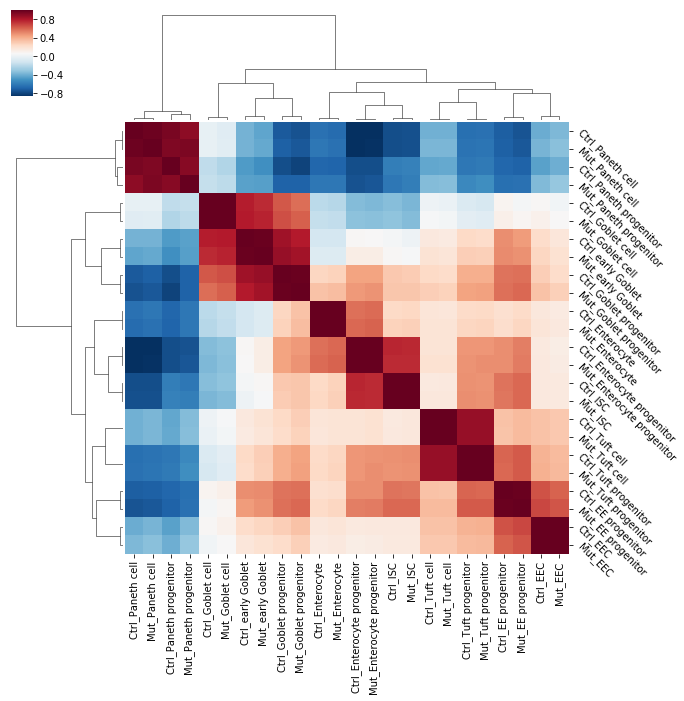

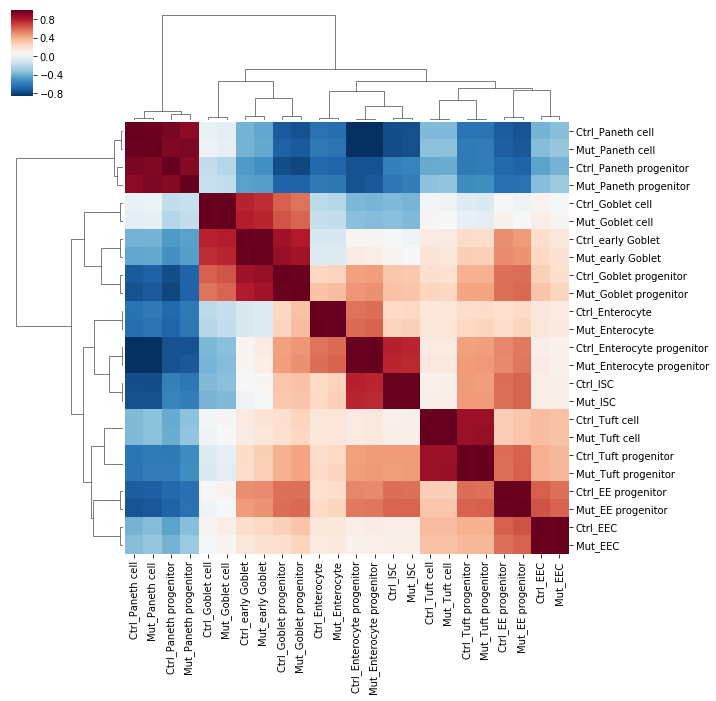

In [20]:
###### calculate correlation  #########

df_cor_pearson=np.corrcoef(df_sort.T)
names=df_sort.columns
df_cor_named_pearson=pd.DataFrame(df_cor_pearson,index=names,columns=names)


##### clustermap  ######
rcParams['figure.figsize']=(5,5)
ax=sns.clustermap(df_cor_named_pearson,cmap='RdBu_r',method='average')
pl.setp(ax.ax_heatmap.get_yticklabels(), rotation=-45)
pl.savefig('./../figures/'+today+'_correlation_progen_mutant_control_clustered.pdf', 
           dpi=300, orientation='landscape',bbox_inches='tight')

pl.show()

###### other correlation measures ######

import sklearn.metrics.pairwise
df_cor_cosine=sklearn.metrics.pairwise.cosine_distances(df_sort.T)
names=df_sort.columns
df_cor_named_cosine=pd.DataFrame(1-df_cor_cosine,index=names,columns=names)

ax=sns.clustermap(df_cor_named_cosine,cmap='RdBu_r', method='average')
pl.show()

# Visualise results of the differential expression test

We have tested all cell types for differentially expressed genes between mutant and control using limma in R. 
In this section, we visualise the results using dotplots. 

Read file with differentially expressed transcription factors.

In [22]:
differential_TFs_mutant_control = pd.read_csv('./../table/TFs_diff_progenitors_mutant_control_2021.csv', 
                                              header=0, index_col=None).x.values

In [24]:
differential_TFs_mutant_control

array(['Ascl2', 'Atf1', 'Atf4', 'Atoh1', 'Barx2', 'Bcl11b', 'Bhlha15',
       'Cdx2', 'Cebpb', 'Creb1', 'Creb3l2', 'Creb3l4', 'Ctcf', 'Dach1',
       'E2f2', 'E2f4', 'Egr1', 'Elf3', 'Eno1', 'Esrra', 'Etv4', 'Fos',
       'Foxa3', 'Foxn3', 'Foxq1', 'Gpbp1l1', 'Gtf2i', 'Hdgf', 'Hnf4g',
       'Irf1', 'Irf8', 'Jun', 'Junb', 'Jund', 'Klf5', 'Klf6', 'Lrrfip1',
       'Max', 'Maz', 'Mlxipl', 'Nfe2l2', 'Nfix', 'Nolc1', 'Nr1h2',
       'Nr3c1', 'Ovol1', 'Ovol2', 'Pcbp1', 'Pitx1', 'Pitx2', 'Ppard',
       'Pura', 'Relb', 'Rpf2', 'Smad1', 'Smad4', 'Sox4', 'Sox9', 'Spdef',
       'Stat1', 'Stat6', 'Tcerg1', 'Tead1', 'Thra', 'Trp53', 'Tsc22d1',
       'Usf2', 'Vdr', 'Vezf1', 'Xbp1', 'Ybx1', 'Zbtb20', 'Zbtb38',
       'Zbtb7b', 'Zfp292', 'Zfp704', 'Zfp771', 'Zfpm1'], dtype=object)

Second, we want to sort the transcription factors based on the logFC and whether they were higher expressed in mutant Paneth primed ISCs vs control Paneth primed ISCs, or mutant Paneth progenitors or control Paneth progenitors.

In [25]:
limma_TFs = pd.read_csv('./../table/limma_results_210209_mutant_control_TFs_intersect.csv', header=0, index_col=0)

In [26]:
limma_TFs.head()

,logFC,AveExpr,adj.P.Val,cell_type
X,,,,
Nolc1,-0.178551,0.974258,2.263530e-07,Goblet progenitor
Creb3l4,0.171877,0.950755,5.972124e-06,Goblet progenitor
Xbp1,0.153297,1.766877,6.385216e-06,Goblet progenitor
Irf1,0.138660,0.588812,8.131906e-06,Goblet progenitor
Jund,0.137995,1.808995,2.859254e-05,Goblet progenitor


We focus on the Paneth cell and Enteroendocrine lineage:

In [29]:
limma_TFs = limma_TFs[np.in1d(limma_TFs['cell_type'], ['ISC', 'Paneth primed ISC',
       'Paneth progenitor', 'Sox4+ early EE progenitor'])]

Let us select TFs for Paneth primed ISCs.

In [33]:
TFs_PISC = limma_TFs[limma_TFs['cell_type']=='Paneth primed ISC'].sort_values('logFC', ascending=False)

In [35]:
TFs_PCpro = limma_TFs[limma_TFs['cell_type']=='Paneth progenitor'].sort_values('logFC', ascending=False)

In [39]:
TFs_PCpro.head()

,logFC,AveExpr,adj.P.Val,cell_type
X,,,,
Foxa3,0.258445,0.743009,1.796813e-11,Paneth progenitor
Bhlha15,0.257968,0.389522,1.554906e-16,Paneth progenitor
Sox9,0.238485,0.773040,4.110931e-09,Paneth progenitor
Atf4,0.228425,0.992297,6.744748e-10,Paneth progenitor
Xbp1,0.209483,1.051458,3.691000e-07,Paneth progenitor


In [8]:
canonical_wnt_genes = [ 'Axin2', 'Ascl2', 'Lgr5', 'Myc', 'Hopx']

In [45]:
receptors = [
    'Fgfr1','Fgfr2','Fgfr3','Fgfr4', #FGF
    'Egfr', 'Erbb2','Erbb3','Lrig1', #EGF 
    'Bmpr1a', 'Bmpr2','Id1','Id2','Id3', #BMP
    'Notch1','Notch2','Notch3','Jag1','Dll1','Dll4','Hes1','Lfng', #Notch 
    'Sfrp5','Sfrp1','Fzd1','Fzd2','Fzd3','Fzd6','Fzd7','Fzd8','Lrp5','Lrp6', #Wnt 
    'Smo', 'Shh', 'Ihh', #Hedgehog
    'Yap1','Tead2', 'Tead3', #Hippo
    'Fzd3', 'Fzd6', 'Ror2', 'Ptk7', 'Celsr1', 'Vangl1', 'Vangl2', 'Prickle1', 'Jun', #Wnt/PCP
    'Ephb2', 'Ephb3', 'Efnb1', #Ephrin signalling
    'Itgb1', 'Itga1','Itga2', 'Itga3', 'Itga5', 'Itga6', 'Itga9' #integrin signalling
]

receptors_valid = [receptor for receptor in receptors if np.in1d(receptor, adata.raw.var_names)]

## Dot plots
### Wnt genes and differential TFs

In [10]:
a_dotplot = adata[np.in1d(adata.obs['cell_type_test'], ['Paneth primed ISC', 
                                                        'Paneth progenitor',
                                                        'Sox4+ early EE progenitor', 
                                                        'Ngn3 progenitor']),:]

In [11]:
a_dotplot

View of AnnData object with n_obs × n_vars = 4930 × 2000 
    obs: 'sample', 'percent_mito', 'percent_ribo', 'n_counts', 'n_genes', 'genetics', 'S_score', 'G2M_score', 'phase', 'cell_type', 'cell_type_refined', 'cell_type_test', 'proma_cell_type'
    var: 'mean', 'dispersion'
    uns: 'cell_type_colors', 'cell_type_refined_colors', 'cell_type_test_colors', 'genetics_colors', 'neighbors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

saving figure to file ./figures/dotplot210209_dotplot_Paneth primed ISC_TFs_PISC_ordered.pdf


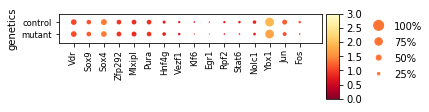

saving figure to file ./figures/dotplot210209_dotplot_Paneth primed ISC_TFs_PCpro_ordered.pdf


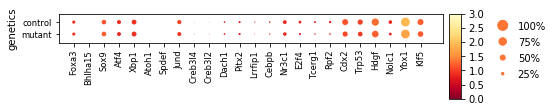

saving figure to file ./figures/dotplot210209_dotplot_Paneth progenitor_TFs_PISC_ordered.pdf


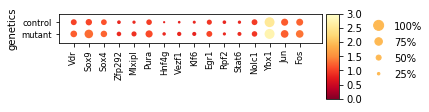

saving figure to file ./figures/dotplot210209_dotplot_Paneth progenitor_TFs_PCpro_ordered.pdf


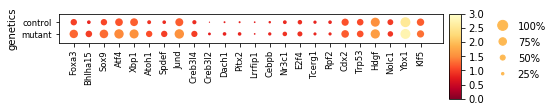

saving figure to file ./figures/dotplot210209_dotplot_Sox4+ early EE progenitor_TFs_PISC_ordered.pdf


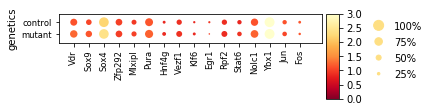

saving figure to file ./figures/dotplot210209_dotplot_Sox4+ early EE progenitor_TFs_PCpro_ordered.pdf


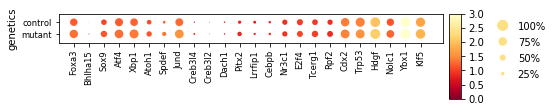

saving figure to file ./figures/dotplot210209_dotplot_Ngn3 progenitor_TFs_PISC_ordered.pdf


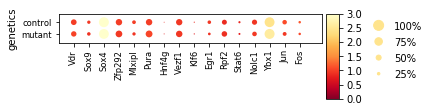

saving figure to file ./figures/dotplot210209_dotplot_Ngn3 progenitor_TFs_PCpro_ordered.pdf


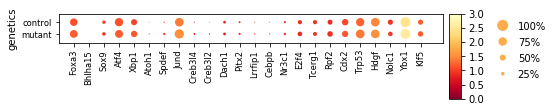

In [40]:
for cell_type in ['Paneth primed ISC', 'Paneth progenitor',
       'Sox4+ early EE progenitor', 'Ngn3 progenitor']:
    
    dotplot(a_dotplot[a_dotplot.obs['cell_type_test']==cell_type,], 
            color_map='YlOrRd_r', max_scale=3, min_scale=0,
            save=today+ '_dotplot_' +cell_type+ '_TFs_PISC_ordered.pdf',
              # var_group_positions = [(0,4), (5,9),(10,15)],
              groupby='genetics', var_names=TFs_PISC.index.values)
    dotplot(a_dotplot[a_dotplot.obs['cell_type_test']==cell_type,], color_map='YlOrRd_r', max_scale=3, min_scale=0,
            save=today+ '_dotplot_' +cell_type+ '_TFs_PCpro_ordered.pdf',
              # var_group_positions = [(0,4), (5,9),(10,15)],
              groupby='genetics', var_names=TFs_PCpro.index.values)


saving figure to file ./figures/dotplot210209_dotplot_Paneth primed ISC_wnt_genes.pdf


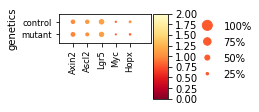

saving figure to file ./figures/dotplot210209_dotplot_Paneth progenitor_wnt_genes.pdf


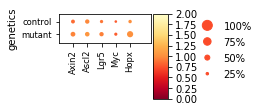

saving figure to file ./figures/dotplot210209_dotplot_Sox4+ early EE progenitor_wnt_genes.pdf


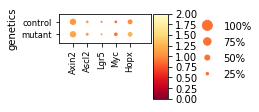

saving figure to file ./figures/dotplot210209_dotplot_Ngn3 progenitor_wnt_genes.pdf


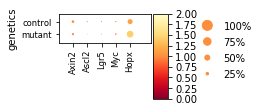

In [41]:
for cell_type in ['Paneth primed ISC', 'Paneth progenitor',
       'Sox4+ early EE progenitor', 'Ngn3 progenitor']:
    
    dotplot(a_dotplot[a_dotplot.obs['cell_type_test']==cell_type,],
            color_map='YlOrRd_r', max_scale=2, min_scale=0,
            save=today+ '_dotplot_' +cell_type+ '_wnt_genes.pdf',
              # var_group_positions = [(0,4), (5,12)],
              groupby='genetics', var_names=canonical_wnt_genes)


saving figure to file ./figures/dotplot210209_dotplot_Paneth primed ISC_receptors.pdf


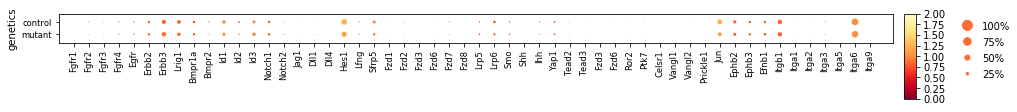

saving figure to file ./figures/dotplot210209_dotplot_Paneth progenitor_receptors.pdf


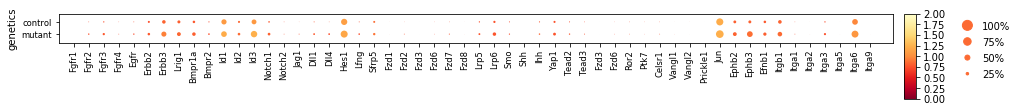

saving figure to file ./figures/dotplot210209_dotplot_Sox4+ early EE progenitor_receptors.pdf


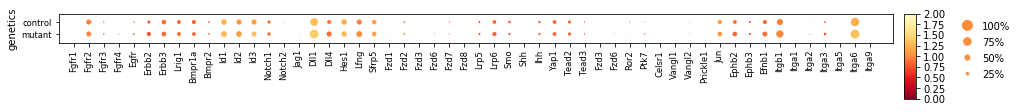

saving figure to file ./figures/dotplot210209_dotplot_Ngn3 progenitor_receptors.pdf


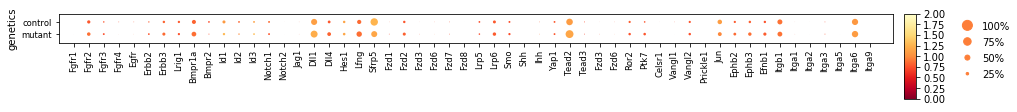

In [47]:
for cell_type in ['Paneth primed ISC', 'Paneth progenitor',
       'Sox4+ early EE progenitor', 'Ngn3 progenitor']:
    
    dotplot(a_dotplot[a_dotplot.obs['cell_type_test']==cell_type,], 
            color_map='YlOrRd_r', max_scale=2, min_scale=0,
            save=today+ '_dotplot_' +cell_type+ '_receptors.pdf',
              #var_group_positions = [(0,4), (5,9), (10,15)],
              groupby='genetics', var_names=receptors_valid)
